## Investments Assignment 7

#### Anita Mezzetti, Hien Le, Francesco Maizza

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import random as random
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import wrds
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
db = wrds.Connection(wrds_username = 'anita97') 

Loading library list...
Done


## a)

In [2]:
#import stocks
'''s = db.raw_sql("select a.permno, a.date, b.exchcd, \
                  a.ret, b.shrcd, a.shrout, a.prc \
                  from crsp.msf as a \
                  join crsp.msenames as b \
                  on a.permno = b.permno and b.namedt<=a.date \
                  and a.date<=b.nameendt \
                  where b.shrcd between (10) and (11) and \
                  a.date >='2000-01-01' and a.date<='2019-12-31'\
                  and b.exchcd between 1 and 2")'''

#s.to_csv('as7.csv')
stocks = pd.read_csv('as7.csv', index_col=0) # read the file

For each value we want one value for each month. Firstly we trasform data column in month-year(format). Then, for each stock we chack that there is only one value for each month:

In [3]:
stocks.date = pd.DatetimeIndex(stocks.date) # data format
stocks.date = stocks.date.dt.to_period('M') # data year-month
stocks = stocks.drop_duplicates(['permno','date']) # delete duplicates
stocks.sort_values(by=['permno','date'])
stocks = stocks.set_index('permno') # set permno as index

In [4]:
# We set also date as index for having a nice output
stocks_output = stocks.reset_index()
stocks_output = stocks_output.set_index(['permno','date'])
stocks_output.head()

exchcd       ret  shrout  shrcd      prc
permno  date                                             
10001.0 2009-12     2.0  0.162621  4361.0   11.0  10.3000
        2010-01     2.0 -0.018932  4361.0   11.0  10.0600
        2010-02     2.0 -0.000656  4361.0   11.0  10.0084
        2010-03     2.0  0.020643  4361.0   11.0  10.1700
        2010-04     2.0  0.124385  6070.0   11.0  11.3900

We have to delete all the stocks which have less than 240 observations. In order to do that, we can group all the stocks on permno (which identify one stock) and then count how many observations we have for each stock:

In [5]:
count = []
count = stocks.groupby('permno').count()
# now in each column we have the number of observations. We can rename one of them
count = count.rename(columns={"date":"number of observations"})
count = count[['number of observations']]
print(f"We have {count.shape[0]} different stocks. Each has a certain number of observations:")
count.head()

We have 4118 different stocks. Each has a certain number of observations:


,number of observations
permno,
10001.0,92
10028.0,140
10042.0,98
10051.0,233
10066.0,28


Now we delete  stocks with less than 240 observations:

Note: This is equal to have only stocks with preciselt 240 observations. Because we want that they are traded EVERY mounth for 20 years: 

20 years*12 mounths = 240 observation. 

In [6]:
decision = count[['number of observations']]!=240 # delete if true
decision = decision.dropna() # drop NaN
decision.head()

,number of observations
permno,
10001.0,True
10028.0,True
10042.0,True
10051.0,True
10066.0,True


In [7]:
decision_true = decision[decision['number of observations']] # keep only true
print(f"We delete {decision_true.shape[0]} stocks.")
stocks_del = stocks.drop(index=decision_true.index) # drop the stocks that have < 240 observations
stocks_del.head()

We delete 3479 stocks.


,date,exchcd,ret,shrout,shrcd,prc
permno,,,,,,
10145.0,2000-01,1.0,-0.167931,789233.0,11.0,48.000000
10145.0,2001-07,1.0,0.059088,809281.0,11.0,36.869999
10145.0,2001-08,1.0,0.015663,811616.0,11.0,37.259998
10145.0,2001-09,1.0,-0.291465,811616.0,11.0,26.400000
10145.0,2001-10,1.0,0.119318,811619.0,11.0,29.549999


We should have 639 stocks:

In [8]:
# we have deleted decision_true
# we are left with the rest of decision
num_deleted = int(decision_true.count())
num_left = int(decision.count()-decision_true.count())
print(f"We have deleted {num_deleted} and we are left with {num_left} stocks")

We have deleted 3479 and we are left with 639 stocks


Delete 3 NaN stocks: fisrt we delete null returns. This operation doesn not remove all the stock obersavations, but only the null ones. In order to cancel all the observations of stocks with NaN values, we re-check that stocks actually have 240 obersations.

In [9]:
stocks_del = stocks_del[~stocks_del.ret.isna()] # delete null returns

In [10]:
count = []
count = stocks_del.groupby('permno').count()
# now in each column we have the number of observations. We can rename one of them
count = count.rename(columns={"date":"number of observations"})
count = count[['number of observations']]
print(f"We have {count.shape[0]} different stocks. Each has a certain number of observations:")
count.head()

We have 639 different stocks. Each has a certain number of observations:


,number of observations
permno,
10145.0,240
10294.0,240
10308.0,240
10516.0,240
10517.0,240


In [11]:
decision = count[['number of observations']]!=240 # delete if true
decision = decision.dropna() # drop NaN
decision.head()

,number of observations
permno,
10145.0,False
10294.0,False
10308.0,False
10516.0,False
10517.0,False


In [12]:
decision_true = decision[decision['number of observations']] # keep only true
print(f"We delete {decision_true.shape[0]} stocks.")
stocks_del = stocks.drop(index=decision_true.index) # drop the stocks that have < 240 observations
stocks_del.head()

We delete 3 stocks.


,date,exchcd,ret,shrout,shrcd,prc
permno,,,,,,
10001.0,2009-12,2.0,0.162621,4361.0,11.0,10.3000
10001.0,2010-01,2.0,-0.018932,4361.0,11.0,10.0600
10001.0,2010-02,2.0,-0.000656,4361.0,11.0,10.0084
10001.0,2010-03,2.0,0.020643,4361.0,11.0,10.1700
10001.0,2010-04,2.0,0.124385,6070.0,11.0,11.3900


In [13]:
# we have deleted decision_true
# we are left with the rest of decision
num_deleted = int(decision_true.count())
num_left = int(decision.count()-decision_true.count())
print(f"We have deleted {num_deleted} and we are left with {num_left} stocks")

We have deleted 3 and we are left with 636 stocks


Now, we can add the risk free rate and market returns. 

In [14]:
# import risk free rate
risk_free = db.raw_sql("select mcaldt as date, tmytm as rf from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='2000-01-01' and mcaldt<='2019-12-31'")
risk_free_m = np.exp(np.divide(risk_free.rf, 1200)) -1
rf = pd.DataFrame([risk_free.date, risk_free_m], index=['date', 'rf']).T

# import market
market = db.raw_sql("select date, vwretd from crsp.msi where date>='2000-01-01' and date<='2019-12-31'")
market_m = pd.DataFrame([market.date, market.vwretd.values], index=['date', 'mkt_ret']).T
rm = market_m.set_index('date')

In [15]:
rf.date = pd.DatetimeIndex(rf.date) # data format
rf.date = rf.date.dt.to_period('M') # data year-month
rf = rf.set_index('date')
rf.head()

,rf
date,
2000-01,0.00449835
2000-02,0.00443834
2000-03,0.00489188
2000-04,0.00440126
2000-05,0.00390314


In [16]:
rm.index = pd.DatetimeIndex(rm.index) # data format
rm.index = rm.index.to_period('M') # data year-month
rm.head()

,mkt_ret
date,
2000-01,-0.0396243
2000-02,0.0317784
2000-03,0.0535007
2000-04,-0.059527
2000-05,-0.0388696


## b)

Caculate market capitalization, making sure that we have absolute values of share prices:

In [17]:
stocks_del['prc'] = stocks_del['prc'].abs() # absolute value of the share price
stocks_del['mrk_cap'] = stocks_del['prc'] * stocks_del['shrout']
stocks_del.head()

,date,exchcd,ret,shrout,shrcd,prc,mrk_cap
permno,,,,,,,
10001.0,2009-12,2.0,0.162621,4361.0,11.0,10.3000,44918.300832
10001.0,2010-01,2.0,-0.018932,4361.0,11.0,10.0600,43871.661830
10001.0,2010-02,2.0,-0.000656,4361.0,11.0,10.0084,43646.632240
10001.0,2010-03,2.0,0.020643,4361.0,11.0,10.1700,44351.370333
10001.0,2010-04,2.0,0.124385,6070.0,11.0,11.3900,69137.302084


Form 10 groups of stocks based on the market capitalization of 31 dec 2019, with first decile being group 1 on so on:

In [18]:
# list of right permnos (no duplicates):
stocks_del = stocks_del.sort_values('permno')
list_permno = list(stocks_del.loc[~stocks_del.index.duplicated(keep='first')].index)

# consider market capitalization on dec 2019
stocks_dec2019 = stocks_del[stocks_del.date.astype(str).values=='2019-12']
stocks_dec2019 = stocks_dec2019.sort_values('permno')
stocks_dec2019.head()

,date,exchcd,ret,shrout,shrcd,prc,mrk_cap
permno,,,,,,,
10028.0,2019-12,2.0,-0.035714,26924.0,11.0,1.350000,3.634740e+04
10051.0,2019-12,1.0,0.053817,37338.0,11.0,27.610001,1.030902e+06
10104.0,2019-12,1.0,-0.056288,3207649.0,11.0,52.980000,1.699412e+08
10145.0,2019-12,1.0,-0.008681,714533.0,11.0,177.000000,1.264723e+08
10158.0,2019-12,1.0,0.070336,29033.0,11.0,17.500000,5.080775e+05


In [19]:
a = pd.qcut(stocks_dec2019.mrk_cap,10)
decile = pd.DataFrame(pd.qcut(stocks_dec2019.mrk_cap,10))
decile = decile.rename(columns={"mrk_cap":"decile"})
decile.head()

,decile
permno,
10028.0,"(1434.059, 93979.937]"
10051.0,"(745103.053, 1332629.841]"
10104.0,"(28751079.177, 437225989.856]"
10145.0,"(28751079.177, 437225989.856]"
10158.0,"(323716.198, 745103.053]"


In [20]:
# compute the size-wheighted returns for a given month 
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [21]:
inters = list(dict.fromkeys(a))
#inters.sort()
inters = [x for x in inters if str(x) != 'nan'] # drop NoN. We always put a control just to be sure
print(f"We have {len(inters)} groups of stcoks.")

We have 10 groups of stcoks.


**EQUALLY WEIGHTED**

In [22]:
group_decile = decile.sort_values(by="decile") # sort for decile
group_decile.reset_index(inplace=True)
group_decile = group_decile.dropna() # drop NaN
group_decile = group_decile.groupby("decile")

In [25]:
ew_ret = [] # returns of equally weighted portfolios
for i in inters:
    stock_interval = group_decile.get_group(i)["permno"]
    temp = stocks_del.loc[stock_interval] 
    group_date = temp.groupby('date').mean()
    ew_ret.append(group_date.ret.mean()) # equal weighted => mean

In [28]:
print("Equally weighted returns:")
print(ew_ret)

Equally weighted returns:
[0.006369841902665764, 0.012620283628252309, 0.011865161286275865, 0.011525543277403415, 0.0140944995986324, 0.012685612596048465, 0.013792344127603974, 0.013302337625005751, 0.014125188780589205, 0.010854069315573927]


For the regression, we need the market risk premium:

In [30]:
group_date

,date,exchcd,ret,shrout,shrcd,prc,mrk_cap
permno,,,,,,,
49322.0,2010-03,1.0,0.135164,11237.0,11.0,10.75,120797.750000
49322.0,2010-02,1.0,-0.144535,11237.0,11.0,9.47,106414.393001
49322.0,2010-01,1.0,-0.096327,11237.0,11.0,11.07,124393.586571
49322.0,2009-12,1.0,0.202159,11237.0,11.0,12.25,137653.250000
49322.0,2009-10,1.0,-0.146067,11237.0,11.0,9.88,111021.561286
...,...,...,...,...,...,...,...
14137.0,2019-02,2.0,0.049320,63200.0,11.0,6.17,389944.004822
14137.0,2019-01,2.0,0.157480,60541.0,11.0,5.88,355981.086928
14137.0,2018-12,2.0,-0.273247,60541.0,11.0,5.08,307548.275381


In [15]:
# list of right permnos (no duplicates):
list_permno = list(stocks_del.loc[~stocks_del.index.duplicated(keep='first')].index)

Create a DataFrame where for each stock we have its beta

In [17]:
data = pd.DataFrame(market_beta, columns={'beta'}, index=list_permno) # for each stock we have its beta
data = data.sort_index()
data.head()

,beta
10145.0,1.200190
10294.0,0.758752
10308.0,0.443625
10516.0,0.497710
10517.0,0.642811


In [18]:
data.shape

(639, 1)

We add to the stocks dataframe our beta, creating a new column:

In [19]:
stocks_del = stocks_del.merge(data, left_index=True, right_index=True)
stocks_del['permno'] = stocks_del.index
stocks_with_beta = stocks_del.drop(stocks_del.loc[stocks_del.beta.isnull()].index).set_index(['permno','date']) # re-index
stocks_with_beta.head()

ret    shrout      prc     beta
permno  date                                         
10145.0 2000-01 -0.167931  789233.0  48.0000  1.20019
        2000-02  0.006510  795134.0  48.1250  1.20019
        2000-03  0.094805  796591.0  52.6875  1.20019
        2000-04  0.062871  796591.0  56.0000  1.20019
        2000-05 -0.020089  798161.0  54.6875  1.20019

Sort stocks by beta into 10 decile portfolios

In [20]:
decile = pd.DataFrame(pd.qcut(data.beta,10),index=list_permno, columns=["beta"])
decile = decile.rename(columns={'beta':'decile'})
decile.head()

,decile
10145.0,"(1.151, 1.296]"
10294.0,"(0.744, 0.882]"
10308.0,"(0.425, 0.607]"
10516.0,"(0.425, 0.607]"
10517.0,"(0.607, 0.744]"


At this point we should have 10 porfolios:

In [21]:
inters = pd.qcut(data.beta,10).values
inters = list(dict.fromkeys(inters))
#inters.sort()
inters = [x for x in inters if str(x) != 'nan'] # drop NoN. We always put a control just to be sure
print(f"We have {len(inters)} portfolios")

We have 10 portfolios


In [22]:
group_decile = decile.sort_values(by="decile") # sort for decile
group_decile.reset_index(inplace=True)
group_decile = group_decile.dropna() # drop NaN
group_decile = group_decile.groupby("decile")

Equal weighted average return for each portfolio:

In [23]:
ew_ret = [] # returns of equally weighted portfolios
avg_beta = [] # avg beta of equally weighted portfolios
for i in inters:
    stock_interval = group_decile.get_group(i)["index"]
    temp = stocks_with_beta.loc[stock_interval] 
    group_date = temp.groupby('date').mean()
    ew_ret.append(group_date.ret.mean()) # equal weighted => mean
    avg_beta.append(data.loc[stock_interval].mean()[0])

We create a dataframe to show the relation between beta and returns of our 10 portfolios

In [24]:
ret = pd.DataFrame([ew_ret,avg_beta]).transpose() 
ret = ret.rename(columns={0:'ew_ret',1:'avg_beta'})
ret = ret.sort_values(by='avg_beta').reset_index(drop=True)
#ret = ret.set_index('avg_beta')
ret.head(10)

,ew_ret,avg_beta
0,0.010578,0.285315
1,0.011674,0.515390
2,0.011796,0.685130
3,0.012387,0.818324
4,0.012547,0.944647
5,0.011389,1.072443
6,0.011606,1.221790
7,0.013521,1.361476
8,0.012934,1.539029
9,0.013058,1.975603


In [25]:
rm_mean = rm.mkt_ret.mean() 
rf_mean = rf.rf.mean()
excess_rm_rf = rm_mean - rf_mean
print(f"The market has a mean return of {rm_mean} and \nthe risk-free portfolio of {rf_mean}.")

The market has a mean return of 0.005825365536250002 and 
the risk-free portfolio of 0.0013152996576685284.


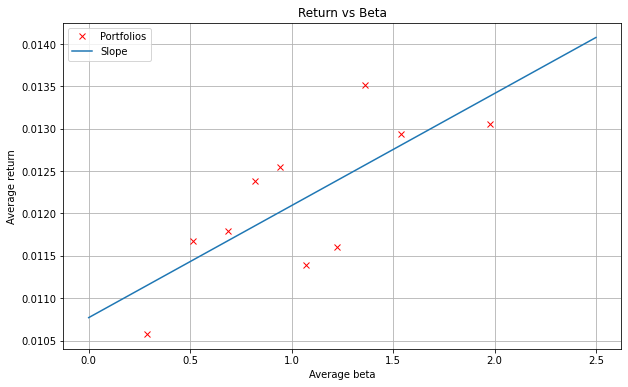

In [26]:
slope, intercept, r_value, p_value, std_err =  stats.linregress([avg_beta[i] for i in range(len(avg_beta))], ew_ret)
plt.figure(figsize=(10,6))
plt.plot(avg_beta, ew_ret, 'rx', label='Portfolios')
plt.plot(np.linspace(0,2.5,100),np.linspace(0,2.5,100)*slope+intercept,label = 'Slope')
plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()

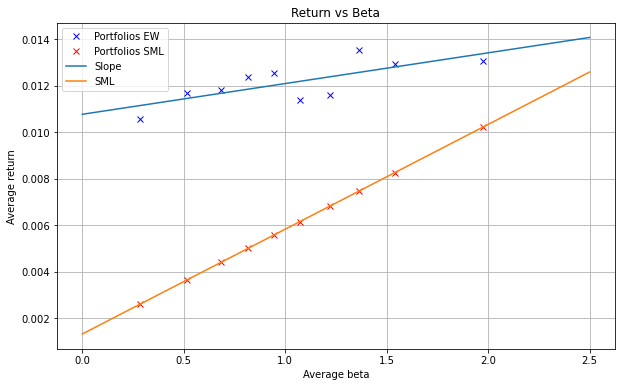

In [27]:
# now compare the slope above with CAPM
slope, intercept, r_value, p_value, std_err =  stats.linregress(avg_beta, ew_ret)
capm_rets = rf_mean + np.array(avg_beta)*excess_rm_rf

plt.figure(figsize=(10,6))

plt.plot(avg_beta, ew_ret, 'bx', label='Portfolios EW') # plot betas against equally weighted returns
plt.plot(avg_beta, capm_rets, 'rx', label='Portfolios SML') 

plt.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100)*slope+intercept,label = 'Slope')
plt.plot(np.linspace(0,2.5,100), rf_mean + np.linspace(0,2.5,100)*excess_rm_rf, label='SML')

plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()

## c)
Notice that the previous results are forward looking in the sense that the strategy
could not have been implemented in real time, since we used the full-sample to
estimate the betas. Instead, we would like to have a test that does not suffer from
look ahead bias. To that end, compute market betas using the period from 2000
to December 31, 2010. Then, starting in 2010, form 10 portfolios as in point b),
but using the betas based on the period from 2000 to 2010. Compute the average
returns (for the sample starting in 2000) and betas (for both samples: the first
one, starting in 2000 and the second one, starting in 2010) for those portfolios.
Plot the average return to these ‘out-of-sample-beta’ decile portfolios in the second
sample period versus their average beta in the first sample period. Also plot the
portfolios’ betas in the second sample period against the portfolios’ betas in the first sample period.

$\textbf{NOTE:}$ I assume that the $\textit{sample starting in 2000}$ means the sample from 2000 to 2010!


In [27]:
# compute market betas from 2000 to 2010 (WARNING: ugly code coming up)

stocks_first_10y = stocks_del[(stocks_del.date >= "2000-1") & (stocks_del.date < "2011-01")]
stocks_next_9y = stocks_del[(stocks_del.date >= "2011-01")]

for num_id in stocks_first_10y.index.unique(): # (list_permno): 
    current_stock = stocks_first_10y.loc[num_id] # long 240 because we have 240 observations for each stock
    ret_cur_stock = current_stock.ret.values.astype(float) # 240 returns for each stock
    rm_cur_stock = rm.loc[current_stock.date].mkt_ret.astype(float)
    covariance = np.cov(ret_cur_stock, rm_cur_stock) # Cov(R,Rm)
    var_market = covariance[1,1]
    stocks_first_10y.at[num_id, "beta"] = covariance[0,1]/var_market
stocks_first_10y = stocks_first_10y.drop(stocks_first_10y.loc[stocks_first_10y.beta.isnull()].index).\
                        set_index(["permno", "date"])

# market betas from 2011 to 2019
for num_id in stocks_next_9y.index.unique(): # (list_permno): 
    current_stock = stocks_next_9y.loc[num_id] # long 240 because we have 240 observations for each stock
    ret_cur_stock = current_stock.ret.values.astype(float) # 240 returns for each stock
    rm_cur_stock = rm.loc[current_stock.date].mkt_ret.astype(float)
    covariance = np.cov(ret_cur_stock, rm_cur_stock) # Cov(R,Rm)
    var_market = covariance[1,1]
    stocks_next_9y.at[num_id, "beta"] = covariance[0,1]/var_market
stocks_next_9y = stocks_next_9y.drop(stocks_next_9y.loc[stocks_next_9y.beta.isnull()].index).\
                        set_index(["permno", "date"])

In [28]:
# the naming of the following variable can be misleading, but it contains the deciles formed by 
# the first-10-years' betas

deciles_next_9y = pd.DataFrame(pd.qcut(stocks_first_10y.beta.unique(),10),index=stocks_first_10y.index.levels[0], 
                               columns=["beta"]) 

# now we get the ten portfolios based on the deciles
portfolios_next_9y = deciles_next_9y.reset_index().groupby(["beta"])["permno"].apply(list)
portfolios_next_9y

beta
(-0.123, 0.367]    [10308.0, 10516.0, 10933.0, 11404.0, 11674.0, ...
(0.367, 0.532]     [11144.0, 11308.0, 11850.0, 11955.0, 13901.0, ...
(0.532, 0.676]     [10294.0, 10517.0, 14541.0, 14816.0, 17005.0, ...
(0.676, 0.82]      [10606.0, 12570.0, 13303.0, 17478.0, 18091.0, ...
(0.82, 0.928]      [11644.0, 12052.0, 13610.0, 13928.0, 15069.0, ...
(0.928, 1.058]     [11018.0, 12211.0, 13769.0, 15202.0, 17961.0, ...
(1.058, 1.229]     [10145.0, 11533.0, 12036.0, 12060.0, 12490.0, ...
(1.229, 1.46]      [11581.0, 11731.0, 13936.0, 14795.0, 17726.0, ...
(1.46, 1.76]       [10866.0, 20618.0, 21055.0, 21573.0, 22779.0, ...
(1.76, 2.938]      [10874.0, 10890.0, 11208.0, 11891.0, 12008.0, ...
Name: permno, dtype: object

In [29]:
insamp_rets = [] # i.e rets the first 10 years - insample rets
outsamp_rets = [] # i.e rets the last 9 years - outsample rets

avg_beta_insamp = [] # i.e avg beta of all ten portfolios from 2000 to 2010
avg_beta_outsamp = [] # i.e avg beta of all ten portfolios from 2011 to 2019

for beta_range in portfolios_next_9y.index:
    stocks = portfolios_next_9y.loc[beta_range] # get the deciles
    avg_beta_insamp.append(stocks_first_10y.beta.loc[stocks].unique().mean()) # stocks_with_beta is the whole sample
    avg_beta_outsamp.append(stocks_next_9y.beta.loc[stocks].unique().mean()) 
    
    # insample calculation first
    insamp = stocks_first_10y.loc[stocks]
    group_date_insamp = insamp.groupby('date').mean()
    insamp_rets.append(group_date_insamp.ret.mean()) # equal weighted => mean
    
    # outsample calculation
    outsamp = stocks_next_9y.loc[stocks]
    group_date_outsamp = outsamp.groupby('date').mean()
    outsamp_rets.append(group_date_outsamp.ret.mean()) # equal weighted => mean

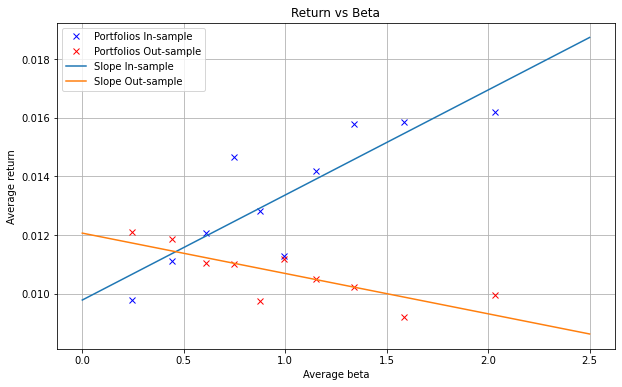

In [30]:
# Plot the average return to these ‘out-of-sample-beta’ decile portfolios in the second
# sample period versus their average beta in the first sample period. 

slope_in, intercept_in, _, _, _ =  stats.linregress(avg_beta_insamp, insamp_rets)
slope_out, intercept_out, _, _, _ =  stats.linregress(avg_beta_insamp, outsamp_rets)


plt.figure(figsize=(10,6))
plt.plot(avg_beta_insamp, insamp_rets, 'bx', label='Portfolios In-sample')
plt.plot(avg_beta_insamp, outsamp_rets, 'rx', label='Portfolios Out-sample')

plt.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100)*slope_in + intercept_in,label = 'Slope In-sample')
plt.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100)*slope_out + intercept_out, label='Slope Out-sample')
plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()

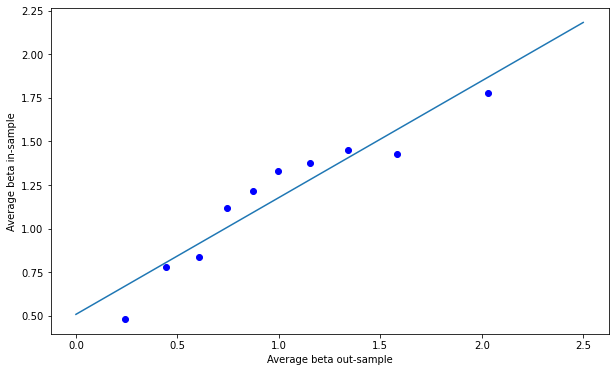

In [33]:
# Also plot the portfolios’ betas in the second sample period against the portfolios’ betas in the
# first sample period.

slope_beta, intercept_beta, _, _, _ =  stats.linregress(avg_beta_insamp, avg_beta_outsamp)

plt.figure(figsize=(10,6))
plt.plot(avg_beta_insamp, avg_beta_outsamp, 'bo')
plt.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100)*slope_beta + intercept_beta, label = 'Slope Avg Betas')
plt.xlabel('Average beta out-sample')
plt.ylabel('Average beta in-sample')
plt.show()